In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from glob import glob
import os
import cartopy.crs as ccrs
import cartopy.feature as cf
from collections import defaultdict
import cartopy.feature as cfeature
import netCDF4 as nc
import os.path as osp
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [2]:
# Open all files
file_path = "/ships22/raqms/Satellite/TEMPO/V03/L3/NO2/2023/"
files = sorted(glob(os.path.join(file_path, "*.nc")))


In [3]:
# open a file
ds = xr.open_dataset(files[0])
print(ds)

# open the groups
ncfile = nc.Dataset(files[0])
print(ncfile)


<xarray.Dataset> Size: 91MB
Dimensions:    (longitude: 7750, latitude: 2950, time: 1)
Coordinates:
  * longitude  (longitude) float32 31kB -168.0 -168.0 -167.9 ... -13.03 -13.01
  * latitude   (latitude) float32 12kB 14.01 14.03 14.05 ... 72.95 72.97 72.99
  * time       (time) datetime64[ns] 8B 2023-08-02T15:13:07.138977024
Data variables:
    weight     (latitude, longitude) float32 91MB ...
Attributes: (12/40)
    history:                          2024-06-03T16:39:32Z: L2_regrid -v /tem...
    scan_num:                         1
    time_coverage_start:              2023-08-02T15:12:49Z
    time_coverage_end:                2023-08-02T16:14:59Z
    time_coverage_start_since_epoch:  1375024387.138977
    time_coverage_end_since_epoch:    1375028117.3767278
    ...                               ...
    title:                            TEMPO Level 3 nitrogen dioxide product
    collection_shortname:             TEMPO_NO2_L3
    collection_version:               1
    keywords:        

In [4]:
# open product group
ds = xr.open_dataset(files[0])
ds_prod = xr.open_dataset(files[0], group='product')
print(ds_prod)
ds_supp = xr.open_dataset(files[0], group='support_data')
print(ds_supp)
ds_geo = xr.open_dataset(files[0], group='geolocation')
print(ds_geo)
ds_qa = xr.open_dataset(files[0], group='qa_statistics')
print(ds_qa)

<xarray.Dataset> Size: 640MB
Dimensions:                                  (time: 1, latitude: 2950,
                                              longitude: 7750)
Dimensions without coordinates: time, latitude, longitude
Data variables:
    vertical_column_troposphere              (time, latitude, longitude) float64 183MB ...
    vertical_column_troposphere_uncertainty  (time, latitude, longitude) float64 183MB ...
    vertical_column_stratosphere             (time, latitude, longitude) float64 183MB ...
    main_data_quality_flag                   (time, latitude, longitude) float32 91MB ...
<xarray.Dataset> Size: 2GB
Dimensions:                            (time: 1, latitude: 2950, longitude: 7750)
Dimensions without coordinates: time, latitude, longitude
Data variables: (12/15)
    vertical_column_total              (time, latitude, longitude) float64 183MB ...
    vertical_column_total_uncertainty  (time, latitude, longitude) float64 183MB ...
    surface_pressure                   

In [5]:
sza = ds_geo['solar_zenith_angle'].squeeze()
lat = ds['latitude'].squeeze()
lon = ds['longitude'].squeeze()
cloud_frac = ds_supp['eff_cloud_fraction'].squeeze()

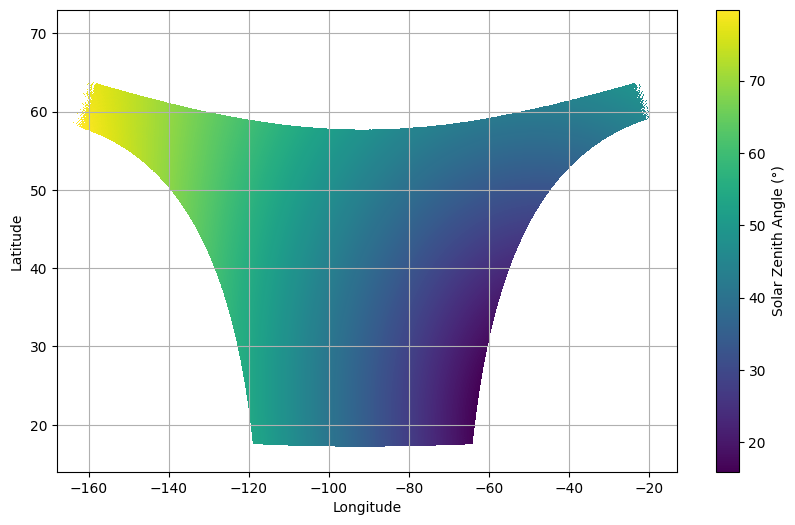

In [6]:
# Plot Solar Zenith Angle (SZA)
plt.figure(figsize=(10, 6))
plt.pcolormesh(lon, lat, sza, shading='auto')
plt.colorbar(label='Solar Zenith Angle (°)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

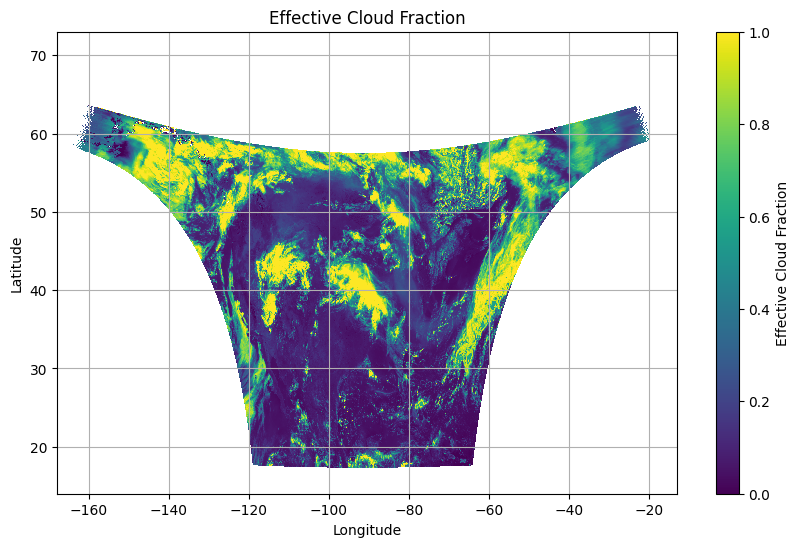

In [7]:
# Plot Effective Cloud Fraction
plt.figure(figsize=(10, 6))
plt.pcolormesh(lon, lat, cloud_frac, shading='auto', cmap='viridis')
plt.colorbar(label='Effective Cloud Fraction')
plt.title('Effective Cloud Fraction')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

In [8]:
# list variables and attributes
for var in ds_prod.data_vars:
    print(f"{var}:\n{ds_prod[var].attrs}\n")

for var in ds_supp.data_vars:
    print(f"{var}:\n{ds_supp[var].attrs}\n")

vertical_column_troposphere:
{'long_name': 'troposphere nitrogen dioxide vertical column', 'units': 'molecules/cm^2'}

vertical_column_troposphere_uncertainty:
{'long_name': 'troposphere nitrogen dioxide vertical column uncertainty', 'units': 'molecules/cm^2'}

vertical_column_stratosphere:
{'long_name': 'stratosphere nitrogen dioxide vertical column', 'units': 'molecules/cm^2'}

main_data_quality_flag:
{'long_name': 'main data quality flag', 'valid_min': np.int16(0), 'valid_max': np.int16(2), 'flag_meanings': 'normal suspicious bad', 'flag_values': array([0, 1, 2], dtype=int32)}

vertical_column_total:
{'long_name': 'nitrogen dioxide vertical column', 'comment': 'nitrogen dioxide vertical column determined from fitted slant column and total AMF calculated from surface to top of atmosphere', 'units': 'molecules/cm^2'}

vertical_column_total_uncertainty:
{'long_name': 'nitrogen dioxide vertical column uncertainty', 'units': 'molecules/cm^2'}

surface_pressure:
{'long_name': 'surface pre

In [9]:
no2trop = ds_prod['vertical_column_troposphere'].squeeze() 
no2strat = ds_prod['vertical_column_stratosphere'].squeeze()
flag = ds_prod['main_data_quality_flag'].squeeze()  

# total column NO2
no2tot = no2trop + no2strat  

# apply filter: flag == 0 and cloud_frac < 0.2
valid_mask = (flag == 0) & (cloud_frac < 0.2)
no2tot_valid = no2tot.where(valid_mask) / 1e16  # convert to 10^16


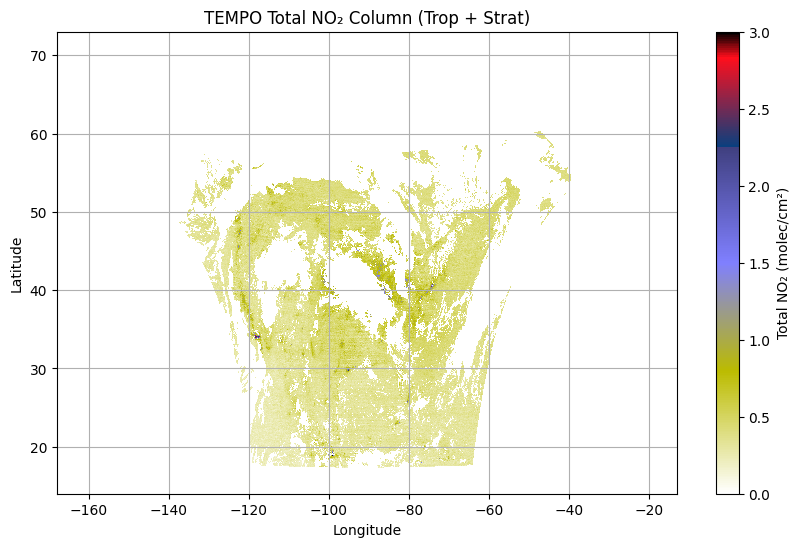

In [10]:
plt.figure(figsize=(10, 6))
plt.pcolormesh(lon, lat, no2tot_valid, shading='auto', vmin = 0, vmax = 3, cmap='gist_stern_r')
plt.colorbar(label='Total NO₂ (molec/cm²)')
plt.title('TEMPO Total NO₂ Column (Trop + Strat)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

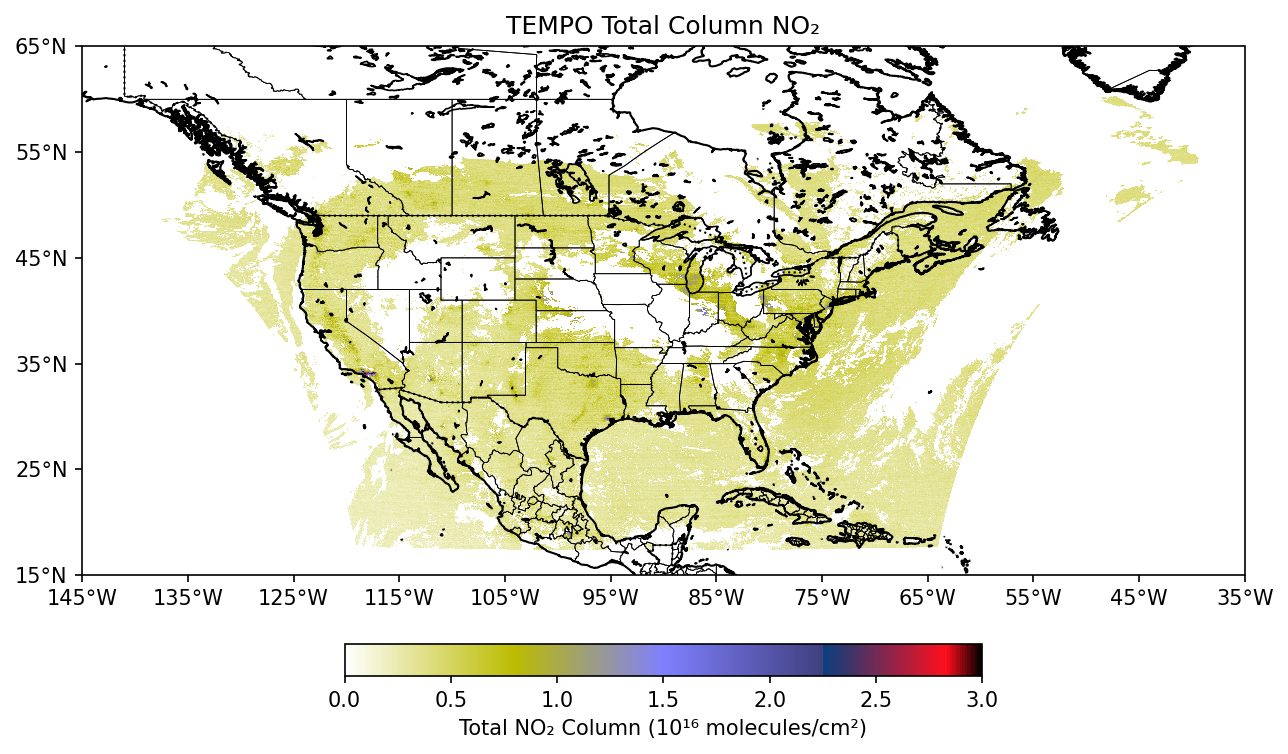

In [11]:
# --------- Helper Functions ---------
def plot_background(ax):
    ax.add_feature(cf.LAKES.with_scale('10m'), facecolor='none', edgecolor='black', linewidth=0.8)
    ax.add_feature(cf.COASTLINE.with_scale('10m'), facecolor='none', edgecolor='black', linewidth=1)
    ax.add_feature(cf.BORDERS.with_scale('10m'), linestyle=':')
    ax.add_feature(cf.STATES.with_scale('10m'), facecolor='none', edgecolor='black', linewidth=0.4)
    return ax

def plot_ticks(ax, lon_min, lon_max, lat_min, lat_max):
    ax.set_xticks(np.arange(np.floor(lon_min), np.ceil(lon_max) + 1, 10), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(np.floor(lat_min), np.ceil(lat_max) + 1, 10), crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter(number_format='.0f', degree_symbol='°'))
    ax.yaxis.set_major_formatter(LatitudeFormatter(number_format='.0f', degree_symbol='°'))
    return ax

lat_min, lat_max = 15, 65
lon_min, lon_max = -145, -35 

# Create a figure
fig = plt.figure(figsize=(10, 6), dpi=150)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
plot_background(ax)
plot_ticks(ax, lon_min, lon_max, lat_min, lat_max)

mesh = ax.pcolormesh(lon, lat, no2tot_valid, transform=ccrs.PlateCarree(),
                     cmap='gist_stern_r', vmin=0, vmax=3)

plt.colorbar(mesh, orientation='horizontal',
             label='Total NO₂ Column (10¹⁶ molecules/cm²)', fraction=0.046, pad=0.1)

ax.set_title(f"TEMPO Total Column NO₂")
plt.savefig(f"TEMPO_NO2.png", facecolor='white', bbox_inches='tight')
plt.show()

In [11]:
# Count flags
total_pixels = np.count_nonzero(~np.isnan(flag))
valid_pixels = np.count_nonzero(flag == 0)
suspicious_pixels = np.count_nonzero(flag == 1)
bad_pixels = np.count_nonzero(flag == 2)

print({total_pixels})
print({valid_pixels*100/total_pixels})
print({suspicious_pixels*100/total_pixels})
print({bad_pixels*100/total_pixels})

{8499966}
{88.34882398353123}
{10.152205314703611}
{1.49897070176516}


In [6]:
file_path = "/ships22/raqms/Satellite/TEMPO/V03/L3/NO2/2023/"
files = sorted(glob(os.path.join(file_path, "*.nc")))

# Grouping files by day
daily_files = {}
for f in files:
    filename = os.path.basename(f)
    timestamp = filename.split('_')[4]  
    date_str = timestamp[:8]            

    if date_str not in daily_files:
        daily_files[date_str] = [f]
    else:
        daily_files[date_str].append(f)

# Print number of files per day
for date, flist in daily_files.items():
    print(f"{date} – {len(flist)} files")


20230802 – 6 files
20230804 – 11 files
20230805 – 11 files
20230806 – 11 files
20230807 – 11 files
20230808 – 6 files
20230809 – 11 files
20230811 – 11 files
20230812 – 9 files
20230815 – 6 files
20230816 – 13 files
20230817 – 6 files
20230818 – 17 files
20230819 – 19 files
20230820 – 19 files
20230821 – 19 files
20230822 – 17 files
20230823 – 48 files
20230825 – 13 files
20230826 – 11 files
20230827 – 35 files
20230828 – 24 files
20230829 – 17 files
20230830 – 16 files
20230831 – 17 files


In [15]:
date = "20230802"
day_files = daily_files[date]
print(day_files)

['/ships22/raqms/Satellite/TEMPO/V03/L3/NO2/2023/TEMPO_NO2_L3_V03_20230802T151249Z_S001.nc', '/ships22/raqms/Satellite/TEMPO/V03/L3/NO2/2023/TEMPO_NO2_L3_V03_20230802T161520Z_S002.nc', '/ships22/raqms/Satellite/TEMPO/V03/L3/NO2/2023/TEMPO_NO2_L3_V03_20230802T171751Z_S003.nc', '/ships22/raqms/Satellite/TEMPO/V03/L3/NO2/2023/TEMPO_NO2_L3_V03_20230802T182022Z_S004.nc', '/ships22/raqms/Satellite/TEMPO/V03/L3/NO2/2023/TEMPO_NO2_L3_V03_20230802T192253Z_S005.nc', '/ships22/raqms/Satellite/TEMPO/V03/L3/NO2/2023/TEMPO_NO2_L3_V03_20230802T202524Z_S006.nc']


/tmp/ipykernel_1390958/4162789372.py:23: RuntimeWarning: Mean of empty slice
  daily_avg = np.nanmean(stacked, axis=0) / 1e16  # convert to 10¹⁶ molecules/cm²


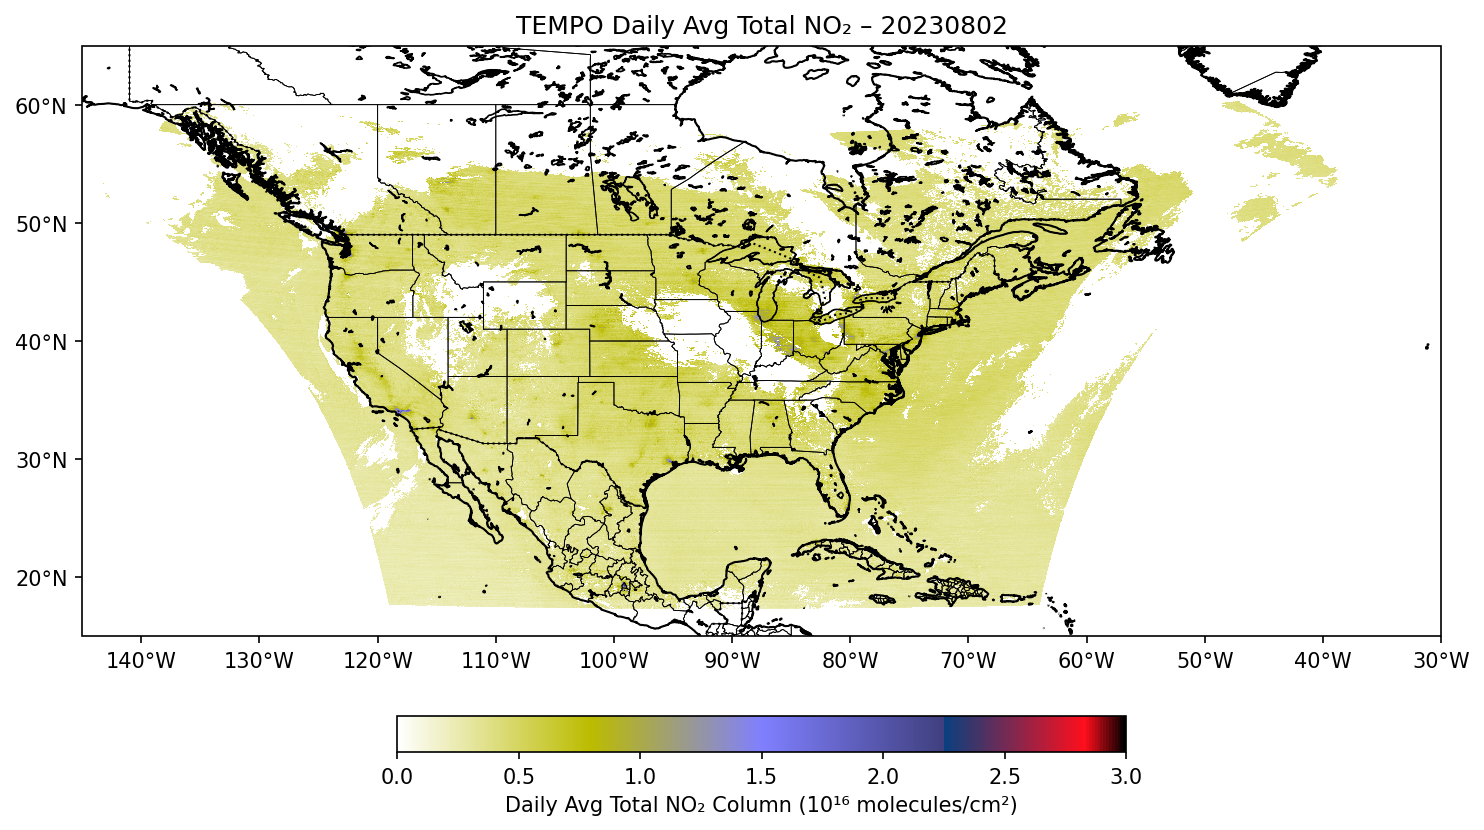

In [ ]:
daily_no2 = []
for file in day_files:
    ds_prod = xr.open_dataset(file, group='product')
    ds_supp = xr.open_dataset(file, group='support_data')
    ds_geo = xr.open_dataset(file, group='geolocation')

    flag = ds_prod['main_data_quality_flag'].squeeze()  
    cloud_frac = ds_supp['eff_cloud_fraction'].squeeze()

    no2trop = ds_prod['vertical_column_troposphere'].squeeze() 
    no2strat = ds_prod['vertical_column_stratosphere'].squeeze()
    # total column NO2
    no2tot = no2trop + no2strat  

    # apply filter: flag == 0 and cloud_frac < 0.15
    valid_mask = (flag == 0) & (cloud_frac < 0.15)
    no2tot_valid = no2tot.where(valid_mask) 

    daily_no2.append(no2tot_valid)

# Combine and average only valid pixels
stacked = np.stack([d.values for d in daily_no2])
daily_avg = np.nanmean(stacked, axis=0) / 1e16  # convert to 10¹⁶ molecules/cm²

# lat/lon data
lat = ds['latitude'].squeeze()
lon = ds['longitude'].squeeze()

# Plotting
fig = plt.figure(figsize=(10, 6), dpi=150)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-145, -35, 15, 65], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cf.LAKES.with_scale('10m'), facecolor='none', edgecolor='black', linewidth=0.8)
ax.add_feature(cf.COASTLINE.with_scale('10m'), facecolor='none', edgecolor='black', linewidth=1)
ax.add_feature(cf.BORDERS.with_scale('10m'), linestyle=':')
ax.add_feature(cf.STATES.with_scale('10m'), facecolor='none', edgecolor='black', linewidth=0.4)

ax.set_xticks(np.arange(-140, -30 + 1, 10), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(20, 60 + 1, 10), crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(LongitudeFormatter(number_format='.0f', degree_symbol='°'))
ax.yaxis.set_major_formatter(LatitudeFormatter(number_format='.0f', degree_symbol='°'))

# Plot data
mesh = ax.pcolormesh(lon, lat, daily_avg, transform=ccrs.PlateCarree(),
                     cmap='gist_stern_r', vmin=0, vmax=3, shading='auto')


plt.colorbar(mesh, orientation='horizontal',
             label='Daily Avg Total NO₂ Column (10¹⁶ molecules/cm²)', fraction=0.046, pad=0.1)

ax.set_title(f"TEMPO Daily Avg Total NO₂ – {date}")
plt.tight_layout()
os.makedirs("TEMPO_Figures", exist_ok=True)
plt.savefig(f"TEMPO_Figures/TEMPO_NO2_DailyAvg_{date}.png", facecolor='white', bbox_inches='tight')
plt.show()

In [ ]:
# Output folder
os.makedirs("TEMPO_Figures", exist_ok=True)

ds = xr.open_dataset(file) 
# lat/lon
lat = ds['latitude'].squeeze()
lon = ds['longitude'].squeeze()

# List of dates
dates = [
    '20230802', '20230803', '20230804', '20230805',
    '20230806', '20230807', '20230808', '20230809', '20230810',
    '20230811', '20230812', '20230813', '20230814', '20230815',
    '20230816', '20230817', '20230818', '20230819', '20230820',
    '20230821', '20230822', '20230823', '20230824', '20230825',
    '20230826', '20230827', '20230828', '20230829', '20230830',
    '20230831'
]

# Loop through each date
for date in dates:
    day_files = daily_files.get(date, [])
    if not day_files:
        continue

    daily_no2 = []

    for file in day_files:
        ds_prod = xr.open_dataset(file, group='product')
        ds_supp = xr.open_dataset(file, group='support_data')

        flag = ds_prod['main_data_quality_flag'].squeeze()
        cloud_frac = ds_supp['eff_cloud_fraction'].squeeze()
        no2trop = ds_prod['vertical_column_troposphere'].squeeze()
        no2strat = ds_prod['vertical_column_stratosphere'].squeeze()
        no2tot = no2trop + no2strat

        valid_mask = (flag == 0) & (cloud_frac < 0.15)
        no2tot_valid = no2tot.where(valid_mask)

        daily_no2.append(no2tot_valid)

    if not daily_no2:
        continue

    # Average using nanmean
    stacked = np.stack([d.values for d in daily_no2])
    daily_avg = np.nanmean(stacked, axis=0) / 1e16  # scale



    # Plot
    fig = plt.figure(figsize=(10, 6), dpi=150)
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-145, -35, 15, 65], crs=ccrs.PlateCarree())

    ax.add_feature(cf.LAKES.with_scale('10m'), facecolor='none', edgecolor='black', linewidth=0.8)
    ax.add_feature(cf.COASTLINE.with_scale('10m'), facecolor='none', edgecolor='black', linewidth=1)
    ax.add_feature(cf.BORDERS.with_scale('10m'), linestyle=':')
    ax.add_feature(cf.STATES.with_scale('10m'), facecolor='none', edgecolor='black', linewidth=0.4)

    ax.set_xticks(np.arange(-140, -30 + 1, 10), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(20, 60 + 1, 10), crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter(number_format='.0f', degree_symbol='°'))
    ax.yaxis.set_major_formatter(LatitudeFormatter(number_format='.0f', degree_symbol='°'))

    mesh = ax.pcolormesh(lon, lat, daily_avg, transform=ccrs.PlateCarree(),
                         cmap='gist_stern_r', vmin=0, vmax=3, shading='auto')

    plt.colorbar(mesh, orientation='horizontal',
                 label='Daily Avg Total NO₂ Column (10¹⁶ molecules/cm²)', fraction=0.046, pad=0.1)

    ax.set_title(f"TEMPO Daily Avg Total NO₂ – {date}")
    plt.tight_layout()
    plt.savefig(f"TEMPO_Figures/TEMPO_NO2_DailyAvg_{date}.png", facecolor='white', bbox_inches='tight')
    plt.close()

    print(f"Saved plot for {date}")


/tmp/ipykernel_2039081/1857674207.py:48: RuntimeWarning: Mean of empty slice
  daily_avg = np.nanmean(stacked, axis=0) / 1e16  # scale


Saved plot for 20230802


/tmp/ipykernel_2039081/1857674207.py:48: RuntimeWarning: Mean of empty slice
  daily_avg = np.nanmean(stacked, axis=0) / 1e16  # scale


Saved plot for 20230804


/tmp/ipykernel_2039081/1857674207.py:48: RuntimeWarning: Mean of empty slice
  daily_avg = np.nanmean(stacked, axis=0) / 1e16  # scale


Saved plot for 20230805


/tmp/ipykernel_2039081/1857674207.py:48: RuntimeWarning: Mean of empty slice
  daily_avg = np.nanmean(stacked, axis=0) / 1e16  # scale


Saved plot for 20230806


/tmp/ipykernel_2039081/1857674207.py:48: RuntimeWarning: Mean of empty slice
  daily_avg = np.nanmean(stacked, axis=0) / 1e16  # scale


Saved plot for 20230807


/tmp/ipykernel_2039081/1857674207.py:48: RuntimeWarning: Mean of empty slice
  daily_avg = np.nanmean(stacked, axis=0) / 1e16  # scale


Saved plot for 20230808


/tmp/ipykernel_2039081/1857674207.py:48: RuntimeWarning: Mean of empty slice
  daily_avg = np.nanmean(stacked, axis=0) / 1e16  # scale


Saved plot for 20230809


/tmp/ipykernel_2039081/1857674207.py:48: RuntimeWarning: Mean of empty slice
  daily_avg = np.nanmean(stacked, axis=0) / 1e16  # scale


Saved plot for 20230811


/tmp/ipykernel_2039081/1857674207.py:48: RuntimeWarning: Mean of empty slice
  daily_avg = np.nanmean(stacked, axis=0) / 1e16  # scale


Saved plot for 20230812


/tmp/ipykernel_2039081/1857674207.py:48: RuntimeWarning: Mean of empty slice
  daily_avg = np.nanmean(stacked, axis=0) / 1e16  # scale


Saved plot for 20230815


/tmp/ipykernel_2039081/1857674207.py:48: RuntimeWarning: Mean of empty slice
  daily_avg = np.nanmean(stacked, axis=0) / 1e16  # scale


Saved plot for 20230816


/tmp/ipykernel_2039081/1857674207.py:48: RuntimeWarning: Mean of empty slice
  daily_avg = np.nanmean(stacked, axis=0) / 1e16  # scale


Saved plot for 20230817


/tmp/ipykernel_2039081/1857674207.py:48: RuntimeWarning: Mean of empty slice
  daily_avg = np.nanmean(stacked, axis=0) / 1e16  # scale


Saved plot for 20230818


/tmp/ipykernel_2039081/1857674207.py:48: RuntimeWarning: Mean of empty slice
  daily_avg = np.nanmean(stacked, axis=0) / 1e16  # scale


Saved plot for 20230819


/tmp/ipykernel_2039081/1857674207.py:48: RuntimeWarning: Mean of empty slice
  daily_avg = np.nanmean(stacked, axis=0) / 1e16  # scale


Saved plot for 20230820


/tmp/ipykernel_2039081/1857674207.py:48: RuntimeWarning: Mean of empty slice
  daily_avg = np.nanmean(stacked, axis=0) / 1e16  # scale


Saved plot for 20230821


/tmp/ipykernel_2039081/1857674207.py:48: RuntimeWarning: Mean of empty slice
  daily_avg = np.nanmean(stacked, axis=0) / 1e16  # scale


Saved plot for 20230822


/tmp/ipykernel_2039081/1857674207.py:48: RuntimeWarning: Mean of empty slice
  daily_avg = np.nanmean(stacked, axis=0) / 1e16  # scale


Saved plot for 20230823


/tmp/ipykernel_2039081/1857674207.py:48: RuntimeWarning: Mean of empty slice
  daily_avg = np.nanmean(stacked, axis=0) / 1e16  # scale


Saved plot for 20230825


/tmp/ipykernel_2039081/1857674207.py:48: RuntimeWarning: Mean of empty slice
  daily_avg = np.nanmean(stacked, axis=0) / 1e16  # scale


Saved plot for 20230826


/tmp/ipykernel_2039081/1857674207.py:48: RuntimeWarning: Mean of empty slice
  daily_avg = np.nanmean(stacked, axis=0) / 1e16  # scale


Saved plot for 20230827


/tmp/ipykernel_2039081/1857674207.py:48: RuntimeWarning: Mean of empty slice
  daily_avg = np.nanmean(stacked, axis=0) / 1e16  # scale


Saved plot for 20230828


/tmp/ipykernel_2039081/1857674207.py:48: RuntimeWarning: Mean of empty slice
  daily_avg = np.nanmean(stacked, axis=0) / 1e16  # scale


Saved plot for 20230829


/tmp/ipykernel_2039081/1857674207.py:48: RuntimeWarning: Mean of empty slice
  daily_avg = np.nanmean(stacked, axis=0) / 1e16  # scale


Saved plot for 20230830


/tmp/ipykernel_2039081/1857674207.py:48: RuntimeWarning: Mean of empty slice
  daily_avg = np.nanmean(stacked, axis=0) / 1e16  # scale


Saved plot for 20230831


In [ ]:
# Paths
file_path = "/ships22/raqms/Satellite/TEMPO/V03/L3/NO2/2023/"
files = sorted(glob(osp.join(file_path, "*.nc")))
files = [f for f in files if osp.basename(f).split("_")[4][:8] >= "20230822"]
base_output_dir = "TEMPO_Scan_Figures"
os.makedirs(base_output_dir, exist_ok=True)

# Speed tip: simplified plotting function
def quick_plot(lon, lat, data, title, out_path):
    fig = plt.figure(figsize=(9, 5), dpi=100)
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-145, -35, 15, 65], crs=ccrs.PlateCarree())

    ax.coastlines(resolution='10m', linewidth=0.7)
    ax.set_xticks(np.arange(-140, -30 + 1, 10), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(20, 60 + 1, 10), crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter(number_format='.0f', degree_symbol='°'))
    ax.yaxis.set_major_formatter(LatitudeFormatter(number_format='.0f', degree_symbol='°'))

    mesh = ax.pcolormesh(lon, lat, data, transform=ccrs.PlateCarree(),
                         cmap='gist_stern_r', vmin=0, vmax=3, shading='auto')

    plt.colorbar(mesh, orientation='horizontal',
                 label='NO₂ Total Column (10¹⁶ molecules/cm²)', fraction=0.046, pad=0.1)

    ax.set_title(title, fontsize=11)
    plt.tight_layout()
    plt.savefig(out_path, facecolor='white', bbox_inches='tight')
    plt.close()

# Loop through all scan files
for file in files:
    filename = osp.basename(file)
    date_str = filename.split("_")[4][:8]  

    # Output folder per day
    output_dir = osp.join(base_output_dir, date_str)
    if not osp.exists(output_dir):
        os.makedirs(output_dir)

    # Open once
    ds = xr.open_dataset(file)
    ds_prod = xr.open_dataset(file, group='product')
    ds_supp = xr.open_dataset(file, group='support_data')

    # Read relevant variables
    flag = ds_prod['main_data_quality_flag']
    cloud_frac = ds_supp['eff_cloud_fraction']
    no2trop = ds_prod['vertical_column_troposphere']
    no2strat = ds_prod['vertical_column_stratosphere']
    no2tot = (no2trop + no2strat) / 1e16  # Scale

    # Mask invalid values
    valid_mask = (flag == 0) & (cloud_frac < 0.15)
    no2tot_valid = no2tot.where(valid_mask).squeeze()

    # Get geolocation once
    lon = ds['longitude']
    lat = ds['latitude']

    # Save
    out_path = osp.join(output_dir, f"{filename.replace('.nc', '.png')}")
    quick_plot(lon, lat, no2tot_valid, f"TEMPO NO₂ – {filename}", out_path)

    print(f"Saved: {out_path}")


Saved: TEMPO_Scan_Figures/20230822/TEMPO_NO2_L3_V03_20230822T104317Z_S001.png
Saved: TEMPO_Scan_Figures/20230822/TEMPO_NO2_L3_V03_20230822T111440Z_S002.png
Saved: TEMPO_Scan_Figures/20230822/TEMPO_NO2_L3_V03_20230822T114603Z_S003.png
Saved: TEMPO_Scan_Figures/20230822/TEMPO_NO2_L3_V03_20230822T121726Z_S004.png
Saved: TEMPO_Scan_Figures/20230822/TEMPO_NO2_L3_V03_20230822T124849Z_S005.png
Saved: TEMPO_Scan_Figures/20230822/TEMPO_NO2_L3_V03_20230822T132012Z_S006.png
Saved: TEMPO_Scan_Figures/20230822/TEMPO_NO2_L3_V03_20230822T142243Z_S007.png
Saved: TEMPO_Scan_Figures/20230822/TEMPO_NO2_L3_V03_20230822T152514Z_S008.png
Saved: TEMPO_Scan_Figures/20230822/TEMPO_NO2_L3_V03_20230822T162745Z_S009.png
Saved: TEMPO_Scan_Figures/20230822/TEMPO_NO2_L3_V03_20230822T173016Z_S010.png
Saved: TEMPO_Scan_Figures/20230822/TEMPO_NO2_L3_V03_20230822T183247Z_S011.png
Saved: TEMPO_Scan_Figures/20230822/TEMPO_NO2_L3_V03_20230822T193518Z_S012.png
Saved: TEMPO_Scan_Figures/20230822/TEMPO_NO2_L3_V03_20230822T203

KeyboardInterrupt: 